<a href="https://colab.research.google.com/github/aryannuka/data-science/blob/main/Copy_of_Nuka_Unit_8_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Unit 8 Project: Predicting Crude Oil Future Volume with BART**

For this project, I chose a dataset containing historical data for Crude Oil WTI Futures. The dataset includes several key financial indicators such as opening, high, low, and settling prices, along with trading volume recorded over various periods. Given that high and low prices are excellent indicators of market volatility and intraday price dynamics, I decided to explore how well these two variables can predict trading volume—the metric that reflects market activity and liquidity.

By implementing a BART model, I was able to assess the non-linear relationships between the high and low prices and the trading volume. This approach not only allowed me to capture the complexity of market behavior but also helped determine which price indicator—high or low—has a stronger influence on the volume. The model provided valuable insights into the underlying dynamics of oil futures trading, ultimately guiding further analysis and potential trading strategies based on the predictive strengths of these financial metrics.

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from sklearn import tree
!pip install pymc-bart
!pip install preliz
import pymc_bart as pmb
import preliz as pz
df = pd.read_csv("https://raw.githubusercontent.com/aryannuka/data-science/refs/heads/main/Crude%20Oil%20WTI%20Futures%20Historical%20Data%20-%20Crude%20Oil%20WTI%20Futures%20Historical%20Data.csv.csv")

In [ ]:
df['Month'] = pd.to_datetime(df['Date']).dt.month_name()
OilIndex = pd.DataFrame(columns=['Month'])
OilIndex['Month'] = pd.Categorical(df['Month'])
month_idx = OilIndex['Month'].cat.codes.values
month_codes = OilIndex['Month'].cat.categories
month_coords = {'Month': month_codes}
df['Month_idx'] = month_idx
print(df.head())

         Date  Price   Open   High    Low     Vol.  Volume Change %  Month  \
0  04/01/2025  71.34  71.41  72.09  71.12  195.50K  195500   -0.07%  April   
1  03/31/2025  71.39  69.43  71.83  68.81    1.89K    1890    2.93%  March   
2  03/28/2025  69.36  69.91  70.09  68.87  246.65K  246650   -0.80%  March   
3  03/27/2025  69.92  69.96  69.97  69.12  211.83K  211830    0.39%  March   
4  03/26/2025  69.65  69.16  70.22  69.06  262.41K  262410    0.94%  March   

   Month_idx  
0          0  
1          7  
2          7  
3          7  
4          7  


Along with the Month, I also focused on the price metrics like the "High", "Low", and overall "Price"—as predictors of trading volume. I chose each of these because they capture different facets of market behavior. For instance, "High" and "Low" reflect the intraday volatility, while "Price" provides a snapshot of the market’s valuation at a given time. On the other hand, converting the "Date" into a categorical "Month" index lets me capture potential seasonal or cyclical effects on trading volume that wouldn't be detected if I only looked at day-to-day price fluctuations.

In [ ]:
values = ["Price", "High", "Low"]
X = df[values]
Y = df["Volume"].to_numpy()

In [ ]:
Y = Y+1

In [ ]:
with pm.Model() as model_octps:
    s = pm.HalfNormal('s',1000)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y)
    idata_octps = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

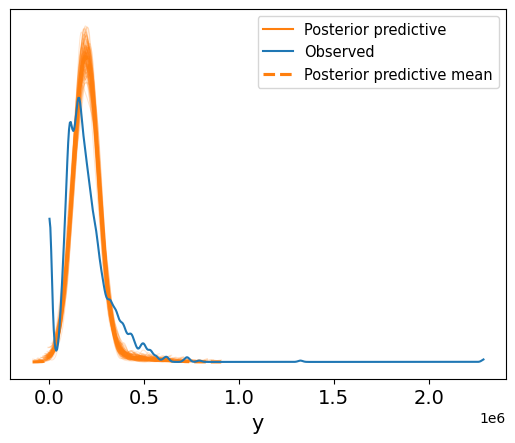

In [ ]:
pm.sample_posterior_predictive(idata_octps,model_octps, extend_inferencedata=True)
az.plot_ppc(idata_octps, num_pp_samples=100, colors=["C1", "C0", "C1"])

The posterior predictive plot fits the data well, although there are extra curves that go out of the predictive range, they didn't affect the curve so this is an accurate representation of the data.

In [ ]:
posterior_mean = idata_octps.posterior["μ"]
μ_hdi = az.hdi(ary=idata_octps, group="posterior", var_names=["μ"], hdi_prob=0.74)
pps = az.extract(
    idata_octps, group="posterior_predictive", var_names=["y"]
).T

In [ ]:
Xn = X.to_numpy()

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


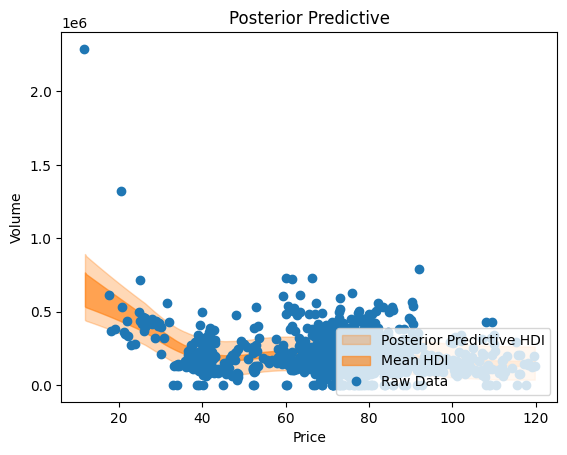

In [ ]:
idx = np.argsort(Xn[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=Xn[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=Xn[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(df["Price"], df["Volume"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="Price",
    ylabel="Volume",
);

The plot shows a predicted trading volume that matches the data closely, showing an inverse relationship between crude oil price and volume—higher prices correspond to lower volumes on average, however we can also a large amount of data points concentrated in the 60-90 price range.

array([<Axes: xlabel='Price'>, <Axes: xlabel='High'>,
       <Axes: xlabel='Low'>], dtype=object)

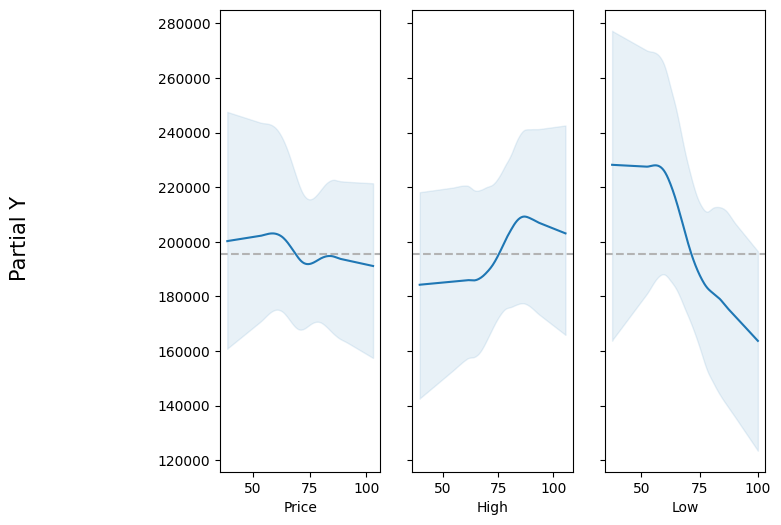

In [ ]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='Price'>, <Axes: xlabel='High'>,
       <Axes: xlabel='Low'>], dtype=object)

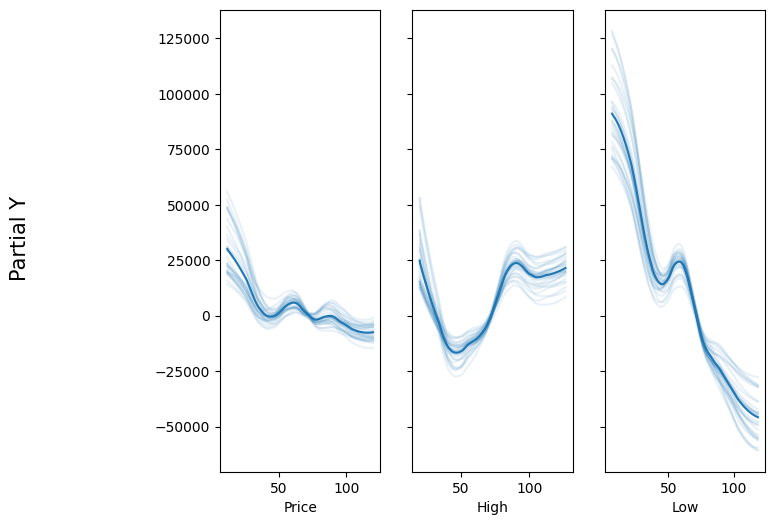

In [ ]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

As I expected, Price had negative correlation with trading volume, with higher prices generally corresponding to lower volumes. However, I was surprised to see that High seemed to have an even stronger influence on predicted volume—indicating that intraday peaks may play a key role in attracting or deterring traders. Meanwhile, Low showed a milder correlation than expected, suggesting that while it captures some volatility, it may not drive trading activity as strongly as the daily highs. Seeing these patterns led me to reconsider the role of price fluctuations in overall market behavior, which shows that traders react more strongly to surging prices than to dips, which ultimately shapes the distribution of trading volume.

In [ ]:
vi_df = pmb.compute_variable_importance(idata_octps, μ_, X)

<Axes: ylabel='R²'>

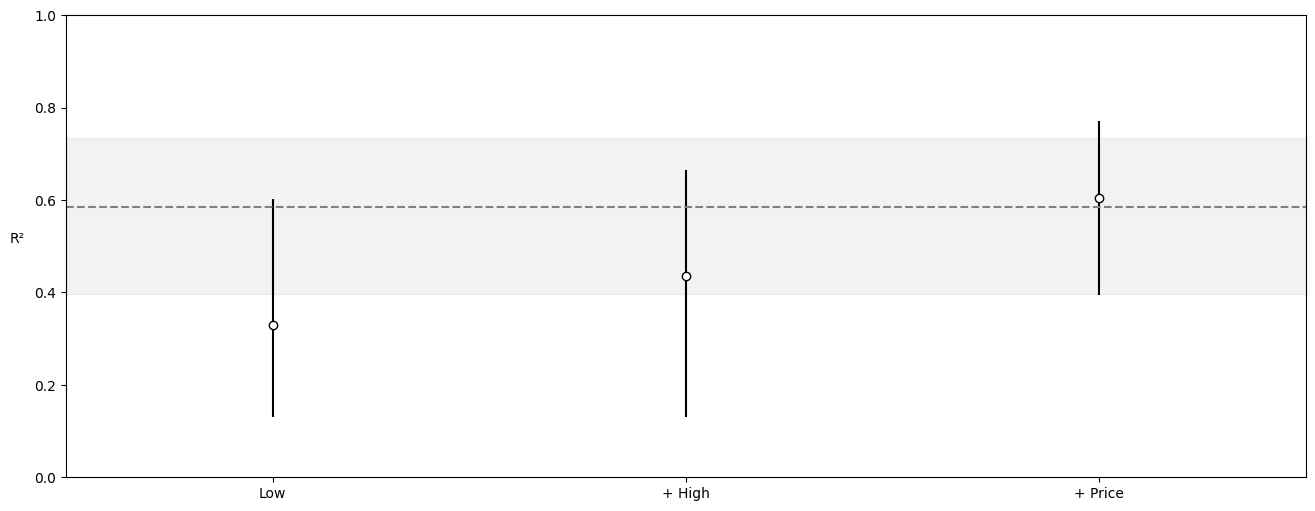

In [ ]:
pmb.plot_variable_importance(vi_df, figsize = (16,6))

Without the low included, the posterior predictive distribution and R² value remain mostly the same, indicating that there were no strong interactions between low and the other predictors (High and Price). Interestingly, removing low slightly increased the relative importance of high, suggesting that intraday peaks might capture some of the variance otherwise attributed to troughs. However, price consistently appears as the primary driver of trading volume, reinforcing the idea that broader price levels significantly influence market activity. Overall, the near-identical results confirm that while Low may reflect part of the daily volatility, it does not substantially reshape the model’s predictive power for volume in this dataset.